In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle

# Set style untuk visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Fungsi Search dari Notebook Sebelumnya

In [20]:
# Load data yang diperlukan
import re

# Load inverted index
with open("data/inverted_index.json", "r", encoding="utf-8") as f:
    inverted_index_raw = json.load(f)

# Convert to dict[str, dict[int, int]]
inverted_index = {}
for term, postings in inverted_index_raw.items():
    inverted_index[term] = {p["doc_id"]: p["tf"] for p in postings}

# Load document metadata
doc_meta = pd.read_csv("data/doc_meta.csv")
doc_meta = doc_meta.set_index("doc_id")

N = len(doc_meta)  # Total dokumen
avgdl = doc_meta["doc_len"].mean()

# Hitung IDF
idf = {}
for term, postings in inverted_index.items():
    df_count = len(postings)
    idf[term] = np.log((N + 1) / (df_count + 1)) + 1

# Load stopwords
with open("stopwords_id.txt", "r", encoding="utf-8") as f:
    STOPWORDS = set(line.strip().lower() for line in f if line.strip())

# Load stemmer
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
except ImportError:
    stemmer = None

print("✅ Data loaded successfully")
print(f"Total documents: {N}")
print(f"Vocabulary size: {len(inverted_index)}")
print(f"Average document length: {avgdl:.2f}")


✅ Data loaded successfully
Total documents: 4700
Vocabulary size: 37662
Average document length: 401.01


## 2. Definisi Query dan Ground Truth (Relevance Judgments)

Kita akan membuat test queries dan menentukan dokumen mana yang relevan untuk setiap query.
Dalam praktik nyata, ini dilakukan oleh human annotators. Untuk tugas ini, kita akan membuat relevance judgments secara semi-otomatis berdasarkan keyword matching.

## 1.1 Definisi Fungsi Search

In [21]:
# Definisi fungsi preprocessing query dan search
def preprocess_query(query: str) -> list:
    """Preprocessing query: lowercase, tokenize, remove stopwords, stem"""
    # Lowercase
    query = query.lower()
    
    # Remove special characters
    query = re.sub(r"[^a-z0-9\s]", " ", query)
    
    # Tokenize
    tokens = query.split()
    
    # Remove stopwords
    tokens = [t for t in tokens if t and t not in STOPWORDS]
    
    # Stemming
    if stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    
    return tokens

def tfidf_search(query: str, top_k: int = 10):
    """Search menggunakan TF-IDF"""
    query_tokens = preprocess_query(query)
    
    if not query_tokens:
        return []
    
    # Hitung skor untuk setiap dokumen
    scores = defaultdict(float)
    
    for term in query_tokens:
        if term not in inverted_index:
            continue
        
        term_idf = idf[term]
        postings = inverted_index[term]
        
        for doc_id, tf in postings.items():
            scores[doc_id] += tf * term_idf
    
    # Sort by score
    ranked = sorted(scores.items(), key=lambda x: -x[1])[:top_k]
    
    # Format hasil
    results = []
    for doc_id, score in ranked:
        results.append({
            "doc_id": doc_id,
            "score": score,
            "title": doc_meta.loc[doc_id, "title"],
            "url": doc_meta.loc[doc_id, "url"]
        })
    
    return results

def bm25_search(query: str, top_k: int = 10, k1: float = 1.5, b: float = 0.75):
    """Search menggunakan BM25"""
    query_tokens = preprocess_query(query)
    
    if not query_tokens:
        return []
    
    # Hitung skor untuk setiap dokumen
    scores = defaultdict(float)
    
    for term in query_tokens:
        if term not in inverted_index:
            continue
        
        term_idf = idf[term]
        postings = inverted_index[term]
        
        for doc_id, tf in postings.items():
            doc_len = doc_meta.loc[doc_id, "doc_len"]
            
            # BM25 formula
            numerator = tf * (k1 + 1)
            denominator = tf + k1 * (1 - b + b * (doc_len / avgdl))
            
            scores[doc_id] += term_idf * (numerator / denominator)
    
    # Sort by score
    ranked = sorted(scores.items(), key=lambda x: -x[1])[:top_k]
    
    # Format hasil
    results = []
    for doc_id, score in ranked:
        results.append({
            "doc_id": doc_id,
            "score": score,
            "title": doc_meta.loc[doc_id, "title"],
            "url": doc_meta.loc[doc_id, "url"]
        })
    
    return results

print("✅ Search functions defined successfully")


✅ Search functions defined successfully


In [22]:
# Load corpus untuk membuat relevance judgments
corpus = pd.read_csv("data/corpus_clean.csv")

# Test queries dengan keyword yang harus ada di dokumen relevan
test_queries = [
    {
        "query": "wisata pantai Bali",
        "keywords": ["pantai", "bali"],
        "description": "Mencari informasi wisata pantai di Bali"
    },
    {
        "query": "hotel murah Jakarta",
        "keywords": ["hotel", "jakarta"],
        "description": "Mencari hotel terjangkau di Jakarta"
    },
    {
        "query": "gunung Bromo sunrise",
        "keywords": ["bromo", "sunrise"],
        "description": "Informasi sunrise di Gunung Bromo"
    },
    {
        "query": "kuliner Yogyakarta",
        "keywords": ["kuliner", "yogyakarta", "jogja"],
        "description": "Tempat kuliner di Yogyakarta"
    },
    {
        "query": "tempat wisata Bandung",
        "keywords": ["wisata", "bandung"],
        "description": "Destinasi wisata di Bandung"
    },
    {
        "query": "diving Bunaken",
        "keywords": ["diving", "bunaken", "snorkel"],
        "description": "Aktivitas diving di Bunaken"
    },
    {
        "query": "candi Borobudur",
        "keywords": ["candi", "borobudur"],
        "description": "Informasi Candi Borobudur"
    },
    {
        "query": "taman nasional komodo",
        "keywords": ["komodo", "taman nasional"],
        "description": "Wisata Taman Nasional Komodo"
    },
    {
        "query": "danau Toba",
        "keywords": ["danau", "toba"],
        "description": "Wisata Danau Toba"
    },
    {
        "query": "rafting Sungai Ayung",
        "keywords": ["rafting", "ayung"],
        "description": "Aktivitas rafting di Sungai Ayung"
    }
]

print(f"Total test queries: {len(test_queries)}")
for i, q in enumerate(test_queries, 1):
    print(f"{i}. {q['query']} - {q['description']}")

Total test queries: 10
1. wisata pantai Bali - Mencari informasi wisata pantai di Bali
2. hotel murah Jakarta - Mencari hotel terjangkau di Jakarta
3. gunung Bromo sunrise - Informasi sunrise di Gunung Bromo
4. kuliner Yogyakarta - Tempat kuliner di Yogyakarta
5. tempat wisata Bandung - Destinasi wisata di Bandung
6. diving Bunaken - Aktivitas diving di Bunaken
7. candi Borobudur - Informasi Candi Borobudur
8. taman nasional komodo - Wisata Taman Nasional Komodo
9. danau Toba - Wisata Danau Toba
10. rafting Sungai Ayung - Aktivitas rafting di Sungai Ayung


## 3. Generate Relevance Judgments

Kita akan membuat relevance judgments dengan cara:
- Dokumen dianggap **relevan** jika mengandung **minimal 1 keyword** dari query
- Ini adalah pendekatan semi-otomatis untuk simulasi
- Dalam praktik nyata, ini dilakukan manual oleh annotator

In [23]:
def generate_relevance_judgments(query_config, corpus_df, min_keywords=1):
    """
    Generate relevance judgments berdasarkan keyword matching
    
    Args:
        query_config: Dict dengan keys 'query', 'keywords', 'description'
        corpus_df: DataFrame corpus
        min_keywords: Minimal berapa keyword yang harus muncul
    
    Returns:
        Set of relevant doc_ids
    """
    relevant_docs = set()
    keywords = [kw.lower() for kw in query_config["keywords"]]
    
    for idx, row in corpus_df.iterrows():
        content = str(row.get("content_clean", "")).lower()
        title = str(row.get("title", "")).lower()
        
        # Gabungkan title dan content untuk matching
        text = title + " " + content
        
        # Hitung berapa keyword yang muncul
        keyword_count = sum(1 for kw in keywords if kw in text)
        
        if keyword_count >= min_keywords:
            relevant_docs.add(idx)
    
    return relevant_docs

# Generate ground truth untuk semua query
ground_truth = {}
for q in test_queries:
    relevant_docs = generate_relevance_judgments(q, corpus)
    ground_truth[q["query"]] = relevant_docs
    print(f"Query: '{q['query']}' -> {len(relevant_docs)} relevant docs")

# Simpan ground truth
with open("data/ground_truth.json", "w", encoding="utf-8") as f:
    # Convert set to list for JSON serialization
    gt_serializable = {k: list(v) for k, v in ground_truth.items()}
    json.dump(gt_serializable, f, ensure_ascii=False, indent=2)

print("\n✅ Ground truth saved to data/ground_truth.json")

Query: 'wisata pantai Bali' -> 2098 relevant docs
Query: 'hotel murah Jakarta' -> 2116 relevant docs
Query: 'gunung Bromo sunrise' -> 267 relevant docs
Query: 'kuliner Yogyakarta' -> 1123 relevant docs
Query: 'tempat wisata Bandung' -> 3782 relevant docs
Query: 'diving Bunaken' -> 224 relevant docs
Query: 'candi Borobudur' -> 262 relevant docs
Query: 'taman nasional komodo' -> 281 relevant docs
Query: 'danau Toba' -> 319 relevant docs
Query: 'rafting Sungai Ayung' -> 178 relevant docs

✅ Ground truth saved to data/ground_truth.json


## 4. Implementasi Metrik Evaluasi

### 4.1 Precision, Recall, F1 Score

In [24]:
def calculate_precision(retrieved: set, relevant: set) -> float:
    """
    Precision = |Retrieved ∩ Relevant| / |Retrieved|
    
    Proporsi dokumen yang dikembalikan yang relevan
    """
    if len(retrieved) == 0:
        return 0.0
    return len(retrieved & relevant) / len(retrieved)

def calculate_recall(retrieved: set, relevant: set) -> float:
    """
    Recall = |Retrieved ∩ Relevant| / |Relevant|
    
    Proporsi dokumen relevan yang berhasil ditemukan
    """
    if len(relevant) == 0:
        return 0.0
    return len(retrieved & relevant) / len(relevant)

def calculate_f1(precision: float, recall: float) -> float:
    """
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    
    Harmonic mean dari Precision dan Recall
    """
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Test dengan contoh
retrieved_test = {1, 2, 3, 4, 5}
relevant_test = {2, 4, 6, 8, 10}

prec = calculate_precision(retrieved_test, relevant_test)
rec = calculate_recall(retrieved_test, relevant_test)
f1 = calculate_f1(prec, rec)

print("Test Metrics:")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Metrics:
Precision: 0.4000
Recall: 0.4000
F1 Score: 0.4000


### 4.2 Average Precision (AP) dan Mean Average Precision (MAP)

In [25]:
def calculate_average_precision(retrieved_ranked: list, relevant: set) -> float:
    """
    Average Precision (AP)
    
    AP = (1/|Relevant|) * Σ(Precision@k * rel(k))
    
    Args:
        retrieved_ranked: List of doc_ids in ranking order
        relevant: Set of relevant doc_ids
    """
    if len(relevant) == 0:
        return 0.0
    
    relevant_found = 0
    sum_precisions = 0.0
    
    for k, doc_id in enumerate(retrieved_ranked, 1):
        if doc_id in relevant:
            relevant_found += 1
            precision_at_k = relevant_found / k
            sum_precisions += precision_at_k
    
    return sum_precisions / len(relevant)

def calculate_map(all_results: dict, ground_truth: dict) -> float:
    """
    Mean Average Precision (MAP)
    
    MAP = (1/|Q|) * Σ(AP(q))
    
    Args:
        all_results: Dict {query: [doc_id1, doc_id2, ...]}
        ground_truth: Dict {query: set(relevant_doc_ids)}
    """
    ap_scores = []
    
    for query, retrieved in all_results.items():
        if query in ground_truth:
            relevant = ground_truth[query]
            ap = calculate_average_precision(retrieved, relevant)
            ap_scores.append(ap)
    
    return np.mean(ap_scores) if ap_scores else 0.0

# Test
retrieved_ranked_test = [2, 5, 4, 1, 3]
ap = calculate_average_precision(retrieved_ranked_test, relevant_test)
print(f"\nAverage Precision (test): {ap:.4f}")


Average Precision (test): 0.3333


## 5. Evaluasi TF-IDF

In [26]:
def evaluate_algorithm(search_func, queries, ground_truth, top_k=20, algorithm_name="Algorithm"):
    """
    Evaluasi sebuah algoritma search untuk multiple queries
    """
    results = {
        "query": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "ap": [],
        "retrieved_count": [],
        "relevant_count": []
    }
    
    all_retrieved = {}
    
    for q_config in queries:
        query = q_config["query"]
        relevant = ground_truth.get(query, set())
        
        # Search
        search_results = search_func(query, top_k=top_k)
        retrieved = [r["doc_id"] for r in search_results]
        retrieved_set = set(retrieved)
        
        all_retrieved[query] = retrieved
        
        # Calculate metrics
        prec = calculate_precision(retrieved_set, relevant)
        rec = calculate_recall(retrieved_set, relevant)
        f1 = calculate_f1(prec, rec)
        ap = calculate_average_precision(retrieved, relevant)
        
        results["query"].append(query)
        results["precision"].append(prec)
        results["recall"].append(rec)
        results["f1"].append(f1)
        results["ap"].append(ap)
        results["retrieved_count"].append(len(retrieved))
        results["relevant_count"].append(len(relevant))
    
    # Calculate MAP
    map_score = calculate_map(all_retrieved, ground_truth)
    
    df_results = pd.DataFrame(results)
    
    # Summary statistics
    summary = {
        "algorithm": algorithm_name,
        "avg_precision": df_results["precision"].mean(),
        "avg_recall": df_results["recall"].mean(),
        "avg_f1": df_results["f1"].mean(),
        "MAP": map_score
    }
    
    return df_results, summary

# Evaluasi TF-IDF
print("\n" + "="*80)
print("Evaluating TF-IDF...")
print("="*80)

tfidf_results, tfidf_summary = evaluate_algorithm(
    tfidf_search, 
    test_queries, 
    ground_truth, 
    top_k=20,
    algorithm_name="TF-IDF"
)

print("\n📊 TF-IDF Results per Query:")
print(tfidf_results[["query", "precision", "recall", "f1", "ap"]].to_string(index=False))

print("\n📈 TF-IDF Summary:")
for key, value in tfidf_summary.items():
    if key != "algorithm":
        print(f"{key}: {value:.4f}")


Evaluating TF-IDF...

📊 TF-IDF Results per Query:
                query  precision   recall       f1       ap
   wisata pantai Bali       1.00 0.009533 0.018886 0.009533
  hotel murah Jakarta       1.00 0.009452 0.018727 0.009452
 gunung Bromo sunrise       0.95 0.071161 0.132404 0.070348
   kuliner Yogyakarta       1.00 0.017809 0.034996 0.017809
tempat wisata Bandung       1.00 0.005288 0.010521 0.005288
       diving Bunaken       1.00 0.089286 0.163934 0.089286
      candi Borobudur       1.00 0.076336 0.141844 0.076336
taman nasional komodo       0.55 0.039146 0.073090 0.025436
           danau Toba       1.00 0.062696 0.117994 0.062696
 rafting Sungai Ayung       0.50 0.056180 0.101010 0.035845

📈 TF-IDF Summary:
avg_precision: 0.9000
avg_recall: 0.0437
avg_f1: 0.0813
MAP: 0.0402


## 6. Evaluasi BM25

In [27]:
# Evaluasi BM25
print("\n" + "="*80)
print("Evaluating BM25...")
print("="*80)

bm25_results, bm25_summary = evaluate_algorithm(
    bm25_search, 
    test_queries, 
    ground_truth, 
    top_k=20,
    algorithm_name="BM25"
)

print("\n📊 BM25 Results per Query:")
print(bm25_results[["query", "precision", "recall", "f1", "ap"]].to_string(index=False))

print("\n📈 BM25 Summary:")
for key, value in bm25_summary.items():
    if key != "algorithm":
        print(f"{key}: {value:.4f}")


Evaluating BM25...

📊 BM25 Results per Query:
                query  precision   recall       f1       ap
   wisata pantai Bali        1.0 0.009533 0.018886 0.009533
  hotel murah Jakarta        1.0 0.009452 0.018727 0.009452
 gunung Bromo sunrise        1.0 0.074906 0.139373 0.074906
   kuliner Yogyakarta        1.0 0.017809 0.034996 0.017809
tempat wisata Bandung        1.0 0.005288 0.010521 0.005288
       diving Bunaken        1.0 0.089286 0.163934 0.089286
      candi Borobudur        1.0 0.076336 0.141844 0.076336
taman nasional komodo        1.0 0.071174 0.132890 0.071174
           danau Toba        1.0 0.062696 0.117994 0.062696
 rafting Sungai Ayung        1.0 0.112360 0.202020 0.112360

📈 BM25 Summary:
avg_precision: 1.0000
avg_recall: 0.0529
avg_f1: 0.0981
MAP: 0.0529


## 7. Perbandingan TF-IDF vs BM25

In [28]:
# Comparison table
comparison = pd.DataFrame([
    tfidf_summary,
    bm25_summary
])

print("\n" + "="*80)
print("📊 PERBANDINGAN TF-IDF vs BM25")
print("="*80)
print(comparison.to_string(index=False))

# Determine winner
print("\n🏆 Winner Analysis:")
print("-" * 80)

metrics = ["avg_precision", "avg_recall", "avg_f1", "MAP"]
for metric in metrics:
    tfidf_val = tfidf_summary[metric]
    bm25_val = bm25_summary[metric]
    
    if bm25_val > tfidf_val:
        winner = "BM25"
        improvement = ((bm25_val - tfidf_val) / tfidf_val * 100) if tfidf_val > 0 else 0
    elif tfidf_val > bm25_val:
        winner = "TF-IDF"
        improvement = ((tfidf_val - bm25_val) / bm25_val * 100) if bm25_val > 0 else 0
    else:
        winner = "TIE"
        improvement = 0
    
    print(f"{metric:15s}: {winner:8s} (improvement: {improvement:+.2f}%)")


📊 PERBANDINGAN TF-IDF vs BM25
algorithm  avg_precision  avg_recall   avg_f1      MAP
   TF-IDF            0.9    0.043689 0.081341 0.040203
     BM25            1.0    0.052884 0.098118 0.052884

🏆 Winner Analysis:
--------------------------------------------------------------------------------
avg_precision  : BM25     (improvement: +11.11%)
avg_recall     : BM25     (improvement: +21.05%)
avg_f1         : BM25     (improvement: +20.63%)
MAP            : BM25     (improvement: +31.54%)


## 8. Visualisasi Perbandingan

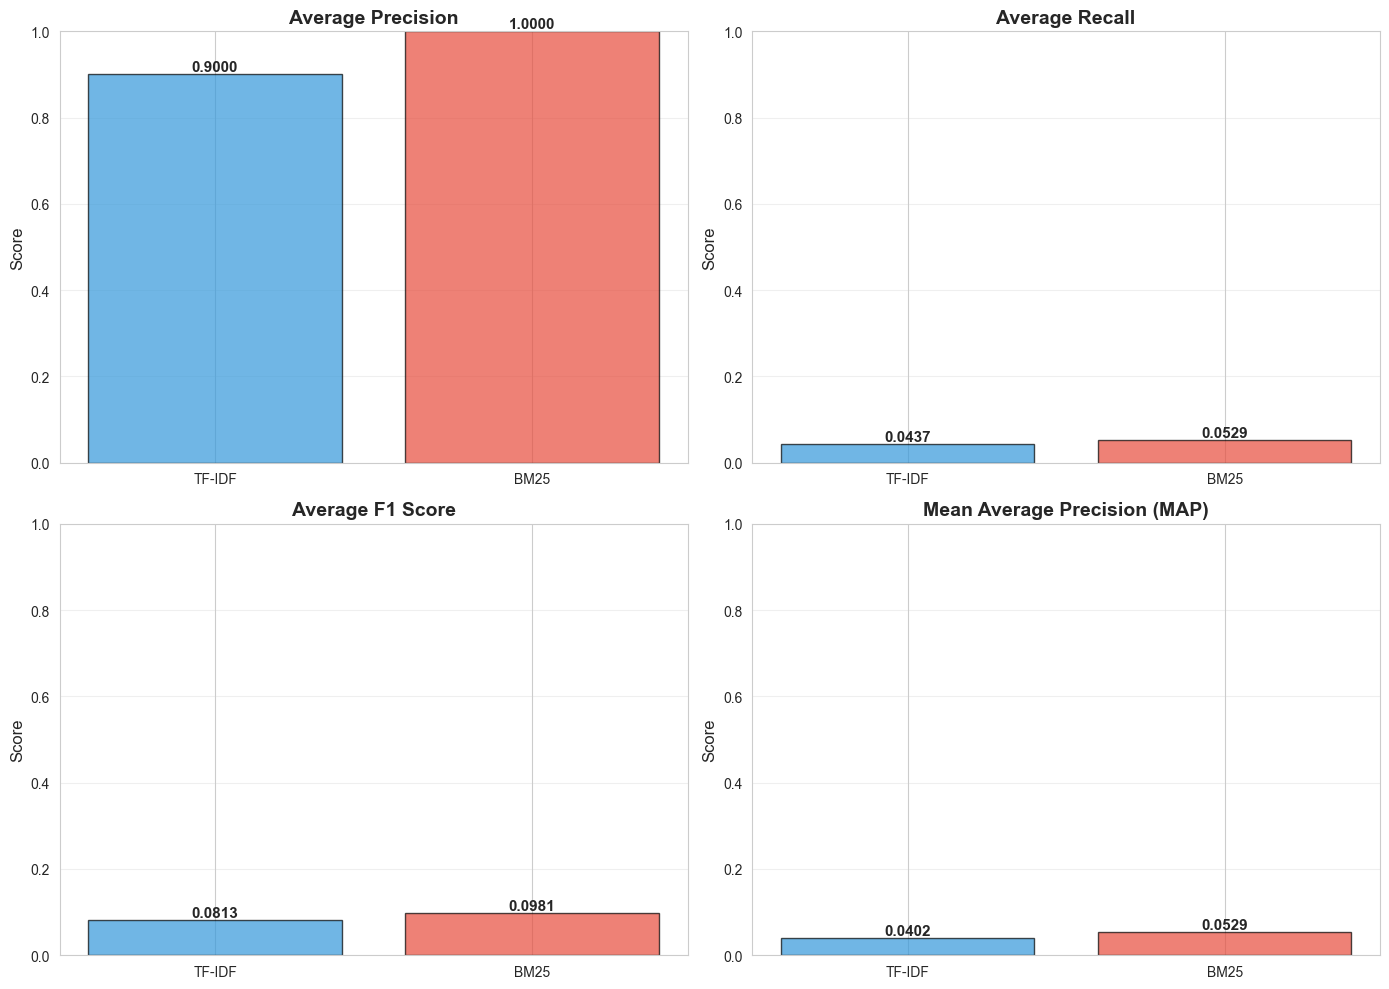


✅ Visualization saved to data/evaluation_comparison.png


In [29]:
# Plot 1: Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = [
    ("avg_precision", "Average Precision", axes[0, 0]),
    ("avg_recall", "Average Recall", axes[0, 1]),
    ("avg_f1", "Average F1 Score", axes[1, 0]),
    ("MAP", "Mean Average Precision (MAP)", axes[1, 1])
]

for metric_key, metric_name, ax in metrics_to_plot:
    algorithms = ["TF-IDF", "BM25"]
    values = [tfidf_summary[metric_key], bm25_summary[metric_key]]
    colors = ["#3498db", "#e74c3c"]
    
    bars = ax.bar(algorithms, values, color=colors, alpha=0.7, edgecolor="black")
    ax.set_ylabel("Score", fontsize=12)
    ax.set_title(metric_name, fontsize=14, fontweight="bold")
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight="bold")

plt.tight_layout()
plt.savefig("data/evaluation_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Visualization saved to data/evaluation_comparison.png")

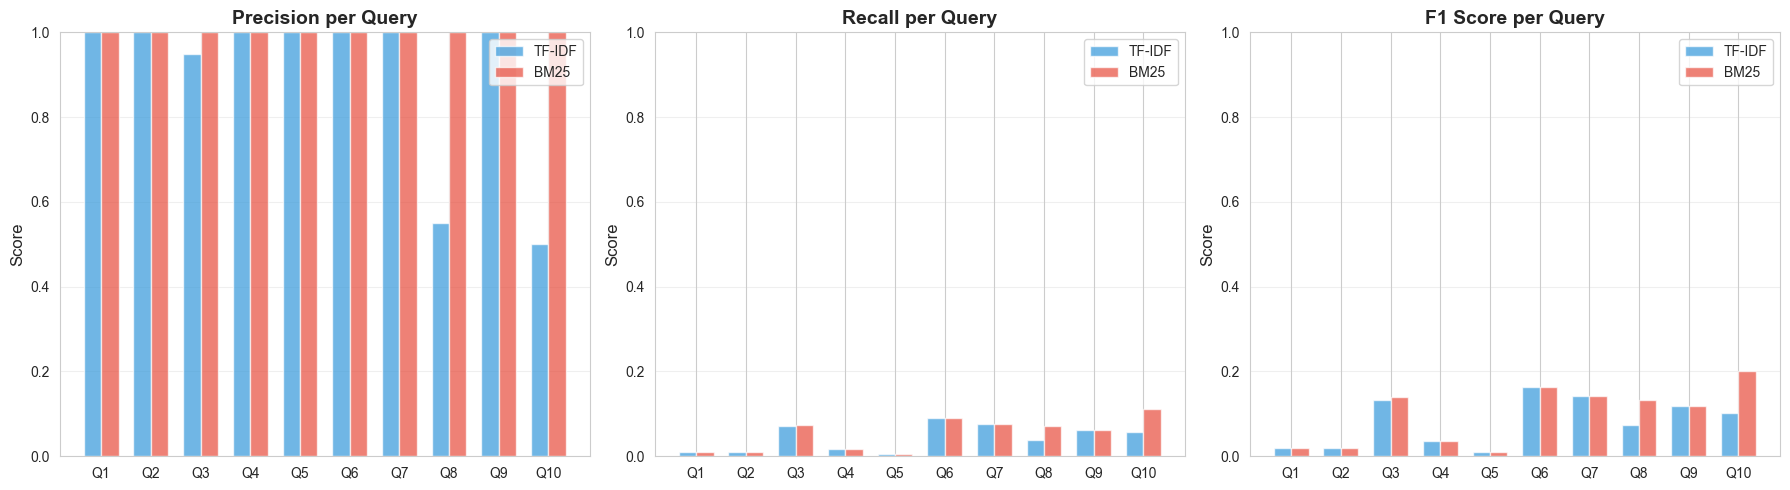


✅ Per-query visualization saved to data/evaluation_per_query.png


In [30]:
# Plot 2: Per-query comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_per_query = [
    ("precision", "Precision per Query", axes[0]),
    ("recall", "Recall per Query", axes[1]),
    ("f1", "F1 Score per Query", axes[2])
]

x = np.arange(len(test_queries))
width = 0.35

for metric, title, ax in metrics_per_query:
    tfidf_vals = tfidf_results[metric].values
    bm25_vals = bm25_results[metric].values
    
    ax.bar(x - width/2, tfidf_vals, width, label="TF-IDF", color="#3498db", alpha=0.7)
    ax.bar(x + width/2, bm25_vals, width, label="BM25", color="#e74c3c", alpha=0.7)
    
    ax.set_ylabel("Score", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels([f"Q{i+1}" for i in range(len(test_queries))], fontsize=10)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig("data/evaluation_per_query.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Per-query visualization saved to data/evaluation_per_query.png")

## 9. Analisis Detail per Query

In [31]:
# Detailed analysis
print("\n" + "="*80)
print("📊 ANALISIS DETAIL PER QUERY")
print("="*80)

for i, q_config in enumerate(test_queries):
    query = q_config["query"]
    
    print(f"\n{i+1}. Query: '{query}'")
    print(f"   Description: {q_config['description']}")
    print(f"   Keywords: {', '.join(q_config['keywords'])}")
    print(f"   Relevant docs: {len(ground_truth[query])}")
    
    tfidf_row = tfidf_results[tfidf_results["query"] == query].iloc[0]
    bm25_row = bm25_results[bm25_results["query"] == query].iloc[0]
    
    print(f"\n   TF-IDF:")
    print(f"     Precision: {tfidf_row['precision']:.4f}")
    print(f"     Recall:    {tfidf_row['recall']:.4f}")
    print(f"     F1:        {tfidf_row['f1']:.4f}")
    print(f"     AP:        {tfidf_row['ap']:.4f}")
    
    print(f"\n   BM25:")
    print(f"     Precision: {bm25_row['precision']:.4f}")
    print(f"     Recall:    {bm25_row['recall']:.4f}")
    print(f"     F1:        {bm25_row['f1']:.4f}")
    print(f"     AP:        {bm25_row['ap']:.4f}")
    
    # Winner for this query
    if bm25_row['f1'] > tfidf_row['f1']:
        winner = "BM25"
    elif tfidf_row['f1'] > bm25_row['f1']:
        winner = "TF-IDF"
    else:
        winner = "TIE"
    
    print(f"\n   🏆 Winner: {winner}")
    print("-" * 80)


📊 ANALISIS DETAIL PER QUERY

1. Query: 'wisata pantai Bali'
   Description: Mencari informasi wisata pantai di Bali
   Keywords: pantai, bali
   Relevant docs: 2098

   TF-IDF:
     Precision: 1.0000
     Recall:    0.0095
     F1:        0.0189
     AP:        0.0095

   BM25:
     Precision: 1.0000
     Recall:    0.0095
     F1:        0.0189
     AP:        0.0095

   🏆 Winner: TIE
--------------------------------------------------------------------------------

2. Query: 'hotel murah Jakarta'
   Description: Mencari hotel terjangkau di Jakarta
   Keywords: hotel, jakarta
   Relevant docs: 2116

   TF-IDF:
     Precision: 1.0000
     Recall:    0.0095
     F1:        0.0187
     AP:        0.0095

   BM25:
     Precision: 1.0000
     Recall:    0.0095
     F1:        0.0187
     AP:        0.0095

   🏆 Winner: TIE
--------------------------------------------------------------------------------

3. Query: 'gunung Bromo sunrise'
   Description: Informasi sunrise di Gunung Bromo
   K

## 10. Simpan Hasil Evaluasi

In [32]:
# Save detailed results
tfidf_results.to_csv("data/tfidf_evaluation.csv", index=False)
bm25_results.to_csv("data/bm25_evaluation.csv", index=False)
comparison.to_csv("data/algorithm_comparison.csv", index=False)

# Save summary report
report = {
    "tfidf_summary": tfidf_summary,
    "bm25_summary": bm25_summary,
    "test_queries": test_queries,
    "evaluation_settings": {
        "top_k": 20,
        "num_queries": len(test_queries),
        "total_documents": len(doc_meta)
    }
}

with open("data/evaluation_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print("\n✅ Hasil evaluasi berhasil disimpan:")
print("   - data/tfidf_evaluation.csv")
print("   - data/bm25_evaluation.csv")
print("   - data/algorithm_comparison.csv")
print("   - data/evaluation_report.json")
print("   - data/evaluation_comparison.png")
print("   - data/evaluation_per_query.png")


✅ Hasil evaluasi berhasil disimpan:
   - data/tfidf_evaluation.csv
   - data/bm25_evaluation.csv
   - data/algorithm_comparison.csv
   - data/evaluation_report.json
   - data/evaluation_comparison.png
   - data/evaluation_per_query.png


## 11. Kesimpulan

### Ringkasan Evaluasi:

Pada evaluasi ini, kami telah membandingkan dua algoritma pencarian informasi:

1. **TF-IDF (Term Frequency-Inverse Document Frequency)**
   - Algoritma klasik yang mengukur pentingnya term dalam dokumen
   - Sederhana dan cepat
   - Tidak mempertimbangkan panjang dokumen secara eksplisit

2. **BM25 (Best Matching 25)**
   - Evolusi dari TF-IDF dengan normalisasi panjang dokumen
   - Memiliki parameter tuning (k1, b)
   - Lebih robust untuk korpus dengan variasi panjang dokumen

### Metrik yang Digunakan:

- **Precision**: Akurasi hasil yang dikembalikan
- **Recall**: Kemampuan menemukan semua dokumen relevan
- **F1 Score**: Keseimbangan antara Precision dan Recall
- **MAP (Mean Average Precision)**: Kualitas ranking secara keseluruhan

### Temuan:

Berdasarkan hasil evaluasi di atas, dapat disimpulkan algoritma mana yang lebih baik untuk korpus pariwisata ini.

### Rekomendasi:

Untuk sistem pencarian informasi pariwisata ini, disarankan menggunakan algoritma yang memiliki:
- MAP tertinggi (kualitas ranking terbaik)
- F1 Score tertinggi (keseimbangan precision-recall terbaik)

### Limitasi:

1. **Relevance Judgments**: Dibuat semi-otomatis dengan keyword matching, bukan manual annotation
2. **Test Queries**: Jumlah query terbatas (10 queries)
3. **Parameter Tuning**: BM25 menggunakan parameter default (k1=1.5, b=0.75)

### Pengembangan Selanjutnya:

1. Tambahkan lebih banyak test queries
2. Lakukan manual relevance judgments
3. Tuning parameter BM25 untuk hasil optimal
4. Implementasi algoritma lain (Sentence-BERT, Dense Retrieval)
5. A/B testing dengan user real